In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Kaggle API

In [2]:
'''
You need the kaggle.json file. To get it you have to log on to the kaggle site, go to the top right of the profile picture,
go to Account and in the API create section do “Create new token.”
'''
from google.colab import files
files.upload()  # Select kaggle.json from your device

# Move kaggle.json in the right dir
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set read permissions

#(train_images, _), (test_images, _) = mnist.load_data() # labels not assigned
#train_images[0]

Saving kaggle.json to kaggle.json


## Loading dataset Fashion Mnist

In [3]:
!pip install -q kaggle

# Download dataset
!kaggle datasets download -d zalando-research/fashionmnist

!unzip -q fashionmnist.zip


Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
  0% 0.00/68.8M [00:00<?, ?B/s]
100% 68.8M/68.8M [00:00<00:00, 1.00GB/s]


## Preprocessing data

In [4]:
!pip install idx2numpy
import idx2numpy
import numpy as np

# Loading images without labels because they are not needed with autoencoder
train_images = idx2numpy.convert_from_file('train-images-idx3-ubyte')
test_images = idx2numpy.convert_from_file('t10k-images-idx3-ubyte')

# Norma between 0 and 1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Adding channel size for convolutions
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

print("Shape training images:", train_images.shape)
print("Shape test images:", test_images.shape)


  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7903 sha256=251ff00d8a292942fdbd50b3982a29bb20aedffa667ad4ef0ac81f06eda00749
  Stored in directory: /root/.cache/pip/wheels/87/e5/e7/70fc742b3645ddf9d392f766feccbcc95cb3a3c806f8588af0
Successfully built idx2numpy
Shape immagini di training: (60000, 28, 28, 1)
Shape immagini di test: (10000, 28, 28, 1)


## Adding noise

In [5]:
# adding random noise
noise_factor = 0.3 # with 0.2 good imgs and avg(PSNR)=25.6
train_images_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape) # normal is the gaussian noise
test_images_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
# The pixel values are clipped to ensure they remain within the valid range of 0 to 1.
train_images_noisy = np.clip(train_images_noisy, 0., 1.)
test_images_noisy = np.clip(test_images_noisy, 0., 1.)

## Autoencoder model creation

In [6]:
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(28, 28, 1))
# Encoder
x = Conv2D(32, (5, 5), padding='same')(input_layer)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Dropout(0.2)(x)

# Decoder 3
x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

x = Conv2DTranspose(32, (5, 5), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

output_layer = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


## Training the autoencoder

In [7]:
# training
batch_size = 128
epochs = 100
# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(train_images_noisy, train_images, batch_size=batch_size, epochs=epochs, validation_data=(test_images_noisy, test_images), callbacks=[early_stopping])

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.0337 - val_loss: 0.0333
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - loss: 0.0095 - val_loss: 0.0126
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0084 - val_loss: 0.0078
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 12/100
469/46

## Denoising test images

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


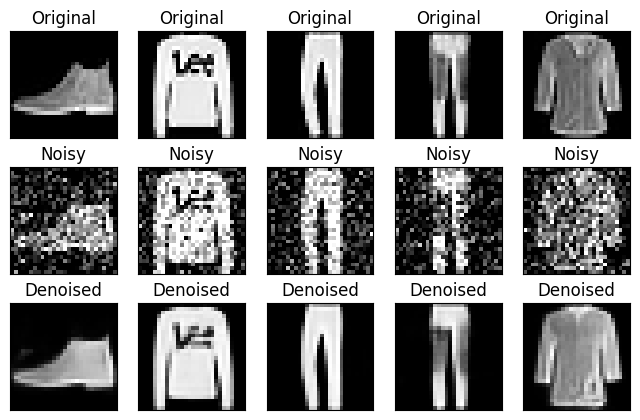

In [8]:
denoised_test_images = autoencoder.predict(test_images_noisy)

n = 5
plt.figure(figsize=(8, 5))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(test_images_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(denoised_test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Performance evaluation

In [9]:
# Evaluation with PSNR
from skimage.metrics import peak_signal_noise_ratio

psnr_values = []
for i in range(len(test_images_noisy)):
    psnr = peak_signal_noise_ratio(test_images[i], denoised_test_images[i])
    psnr_values.append(psnr)
    if i<5: print(f"PSNR for image {i + 1}: {psnr}")

average_psnr = np.mean(psnr_values)
print(f"Average PSNR: {average_psnr}")


PSNR for image 1: 24.33506481960556
PSNR for image 2: 20.800853163373226
PSNR for image 3: 23.645060946084758
PSNR for image 4: 22.831859213095306
PSNR for image 5: 21.53502734007061
Average PSNR: 22.158661495703207


In [10]:
from sklearn.metrics import mean_squared_error

mse_values = []
for i in range(len(test_images)):
    mse = mean_squared_error(test_images[i].flatten(), denoised_test_images[i].flatten())
    mse_values.append(mse)
    if i < 5:
        print(f"MSE for image {i + 1}: {mse}")

average_mse = np.mean(mse_values)
print(f"Average MSE: {average_mse}")


MSE for image 1: 0.0036854753270745277
MSE for image 2: 0.00831600371748209
MSE for image 3: 0.004320101346820593
MSE for image 4: 0.005209716036915779
MSE for image 5: 0.0070225889794528484
Average MSE: 0.006788480236043688
